In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries

In [30]:
import sys
sys.path.append('../input/iterativestratification')

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.losses import binary_crossentropy
from keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture


# Import and split data

In [31]:
#PATH_TRAIN = '/kaggle/input/icr-identify-age-related-conditions/train.csv'
#PATH_TEST = '/kaggle/input/icr-identify-age-related-conditions/test.csv'

PATH_TRAIN = 'train.csv'
#PATH_TEST = 'test.csv'

df =  pd.read_csv(PATH_TRAIN).drop(columns='Id')

y = df['Class']
X = df.drop(columns='Class')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)


X_train.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
260,0.192285,2382.25889,94.396851,10.613419,8.138688,3.791652,0.025578,15.578544,1.229900,4677.87334,...,10.386492,7.362558,1.15971,0.230282,25.022380,72.611063,6000.327558,43.587794,63.505252,0.139765
238,0.205104,2448.53785,85.200147,11.889383,8.138688,3.756216,0.052069,13.190086,5.987856,6357.29144,...,9.383126,10.791274,1.74203,0.291239,23.896838,72.611063,2629.423539,28.260995,64.796396,0.076761
409,0.478576,5994.53602,85.200147,27.222630,10.781664,6.103851,0.025578,13.732058,1.229900,6366.94336,...,3.583450,0.173229,1.30790,0.067730,33.924394,72.611063,41711.321300,31.933622,68.474356,21.978000
531,0.397389,1055.33538,85.200147,62.686377,18.702726,4.323192,0.062422,13.316126,6.100304,5290.78624,...,3.583450,0.173229,1.54686,0.067730,34.445306,72.611063,104289.371700,32.956897,19.678372,21.978000
317,0.316202,2688.97090,85.200147,12.090688,8.138688,5.926671,0.025578,8.539210,1.229900,3872.17772,...,10.573934,0.173229,0.49706,0.406380,12.129808,72.611063,44792.362530,42.709638,19.081668,21.978000


# Explore data

In [32]:
print(f'[INFO] Shapes:'
      f'\n[+] train  -> {X_train.shape}'
      f'\n[+] test   -> {X_test.shape}\n')

print(f'[INFO] Any missing values:'
      f'\n[+] train  -> {X_train.isna().any().any()}'
      f'\n[+] test   -> {X_test.isna().any().any()}')

missing = X_train.isna().sum().reset_index()
missing.columns = ['columns', 'missing_count']

print(f'[INFO] Any missing values:'
      f'\n\n{missing[missing.missing_count > 0]}')

[INFO] Shapes:
[+] train  -> (524, 56)
[+] test   -> (93, 56)

[INFO] Any missing values:
[+] train  -> True
[+] test   -> True
[INFO] Any missing values:

   columns  missing_count
12      BQ             55
15      CB              2
16      CC              3
32      DU              1
40      EL             57
43      FC              1
47      FL              1
49      FS              2
55      GL              1


# Categorical data into float

In [33]:
column_train = X_train['EJ']
column_test = X_test['EJ']
print(f'Values in EJ train:\n{column_train.value_counts()}'
    f'\nValues in EJ test:\n{column_test.value_counts()}')

X_train['EJ'].replace({'A': 0.0, 'B': 1.0}, inplace=True)
X_test['EJ'].replace({'A': 0.0, 'B': 1.0}, inplace=True)

#X_test.dtypes


Values in EJ train:
B    339
A    185
Name: EJ, dtype: int64
Values in EJ test:
B    56
A    37
Name: EJ, dtype: int64


# Impute missing values

In [34]:
imputer = KNNImputer(n_neighbors=10)
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

print(f'[INFO] Any missing values:'
    f'\n[+] train  -> {X_train.isna().any().any()}'
    f'\n[+] test  -> {X_test.isna().any().any()}')


[INFO] Any missing values:
[+] train  -> False
[+] test  -> False


# Normalize

In [35]:
#Normalize
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f'[INFO] Shape:'
    f'\n[+] train  -> {X_train_scaled.shape}'
    f'\n[+] test  -> {X_test_scaled.shape}')

[INFO] Shape:
[+] train  -> (524, 56)
[+] test  -> (93, 56)


# Create clusters 

In [36]:
# Add cluster feature
def add_cluster (df, n_clusters):
    #kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    #kmeans.fit(df)
    #labels = kmeans.labels_
    
    labels = GaussianMixture(n_components=n_clusters, random_state=0).fit_predict(df)
           
    df = np.column_stack((df, labels/n_clusters))
    return df




# Visualize new feature (clusters)

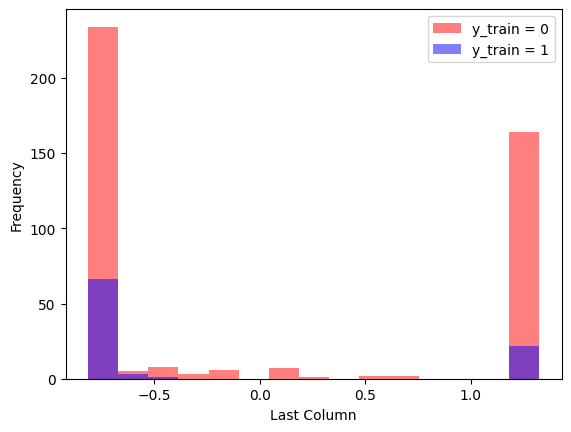

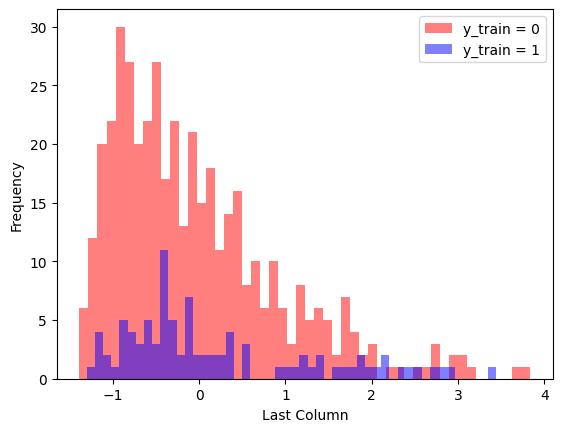

In [37]:
import matplotlib.pyplot as plt

last_column = X_train_scaled[:, -1]

plt.hist(last_column[y_train == 0], bins=15, color='red', alpha=0.5, label='y_train = 0')
plt.hist(last_column[y_train == 1], bins=15, color='blue', alpha=0.5, label='y_train = 1')

plt.xlabel('Last Column')
plt.ylabel('Frequency')
plt.legend()
plt.show()

last_column = X_train_scaled[:, -2]

plt.hist(last_column[y_train == 0], bins=50, color='red', alpha=0.5, label='y_train = 0')
plt.hist(last_column[y_train == 1], bins=50, color='blue', alpha=0.5, label='y_train = 1')

plt.xlabel('Last Column')
plt.ylabel('Frequency')
plt.legend()
plt.show()






Some clusters are promising

# Create and train model

In [38]:
def model_train(X_train, y_train, nodes, n_layers, epochs, activation, optimizer, loss):
    
    input_dim = X_train.shape[1]
    
    #Create model
    model = Sequential()
    model.add(Dense(nodes, input_dim = input_dim, activation=activation))
    for i in range(n_layers-2):
        model.add(Dense(nodes, activation=activation))
        #model.add(LeakReLU(aplha=0.1))
    model.add(Dense(1, activation='sigmoid'))

    #Compile model
    model.compile(loss=loss, optimizer=optimizer)

    #Train model
    model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=0)

    return model



# Make predictions and submit

In [39]:
def model_eval(new_features):
    
    df_test = pd.DataFrame(columns=['Features', 'Epochs', 'Nodes', 'Layers', 'Logloss'])

    for features in range(new_features):
        X_train = add_cluster(X_train_scaled, (features +1) * 15)
        X_test = add_cluster(X_test_scaled, (features + 1) * 15)

        for epochs in range(25, 26, 25):
            for nodes in range(10, 11, 2):
                for layers in range(2, 3, 1):
                    log_prom = []

                    for i in range(5):
                        model = model_train(X_train, y_train, nodes, layers, epochs, 'tanh', 'adam', 'binary_crossentropy')
                        y_pred = model.predict(X_test)
                        log_prom.append(log_loss(y_test, y_pred))

                    print(f'[INFO] Features: {features + 1} Epochs: {epochs} Nodes: {nodes} Layers: {layers}')
                    print(f'[INFO] Logloss: {np.mean(log_prom)}')
                    print('\n=============================================================================')
                    df_test = df_test.append({'Features': features + 1, 'Epochs': epochs, 'Nodes': nodes, 'Layers': layers, 'Logloss': np.mean(log_prom)}, ignore_index=True)

    return df_test

df_test = model_eval(2)
print(df_test.loc[df_test['Logloss'].idxmin()])

3/3 [==============================] - 0s 2ms/step
[INFO] Features: 1 Epochs: 25 Nodes: 10 Layers: 2
[INFO] Logloss: 0.25549382329594716

3/3 [==============================] - 0s 993us/step
[INFO] Features: 2 Epochs: 25 Nodes: 10 Layers: 2
[INFO] Logloss: 0.24952450988561656

Features     2.000000
Epochs      25.000000
Nodes       10.000000
Layers       2.000000
Logloss      0.249525
Name: 1, dtype: float64


In [40]:
df_test.to_csv('model_test.csv', index=False)

In [41]:
criterio = df_test['Features'] == 3
df_test.loc[criterio, 'Logloss'].mean()

nan

In [42]:
y_pred = model.predict(X_test_scaled)

sub = pd.DataFrame()

y_test = y_test.reset_index(drop=True)
sub = sub.reset_index(drop=True)

sub['class_0'] = (1 - y_pred.flatten()).round(5)
sub['class_1'] = y_pred.flatten().round(5)
y_test = y_test.astype(float)
sub['real'] = y_test.round(0)

filtered = sub[abs(sub['real'] - sub['class_1']) > 0.99]
print(filtered)

from sklearn.metrics import log_loss
binary = np.where(y_pred >= 0.01, 1, 0)

# Obtener las probabilidades predichas en el conjunto de prueba
y_pred_prob = model.predict(X_test_scaled)

# Calcular el logloss utilizando la función log_loss de SciPy
logloss = log_loss(y_test, y_pred_prob)
loglossbinary = log_loss(y_test, binary)

print("LogLoss:", logloss)
print("LogLoss binary:", loglossbinary)

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las etiquetas predichas en el conjunto de prueba
#y_pred = model.predict_classes(X_test_scaled)
binary = np.where(y_pred >= 0.5, 1, 0)

# Calcular la matriz de confusión
confusion = confusion_matrix(y_test, binary)

# Visualizar la matriz de confusión
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()